# Setup

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import torch                                      # root package
from torch.utils.data import Dataset, DataLoader  # dataset representation and loading
import torch.nn as nn                             # neural networks
import torch.optim as optim                       # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets
from torchvision.transforms import ToTensor

# 03 Computer vision

Bellow are some common pytorch computer vision libraries:

* `torchvision` : base domain library for pytorch comp vision
* `torchvision.datasets` : datasets and data loading functions
* `torchvision.models` : pretrained vision models
* `torchvision.transforms` : functions to manipulate vision data to make it suitable for ML models
* `torch.utils.data.Dataset` : base dataset class for pytorch
* `torch.utils.data.DataLoader` : Creates a python iterable over a dataset

## Agnostic code

In [114]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting data

In [115]:
train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
train_data.data.to(device)
train_data.targets.to(device)
test_data.data.to(device)
test_data.targets.to(device)

tensor([9, 2, 1,  ..., 8, 1, 5], device='cuda:0')

## Visualizing

torch.Size([1, 28, 28])


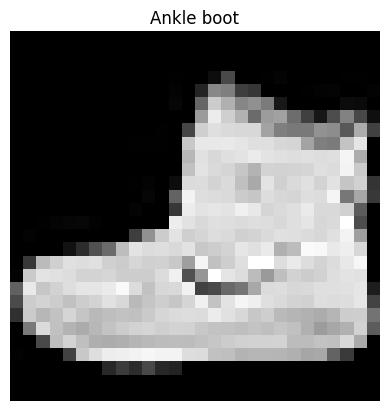

In [116]:
# first examples
train_image,train_label = train_data[0]

print(train_image.shape) #shape is [1,28,28] because images are 28x28 and greyscale

plt.imshow(train_image.squeeze(),
           cmap="gray")
plt.title(train_data.classes[train_label])
plt.axis(False)
plt.show()

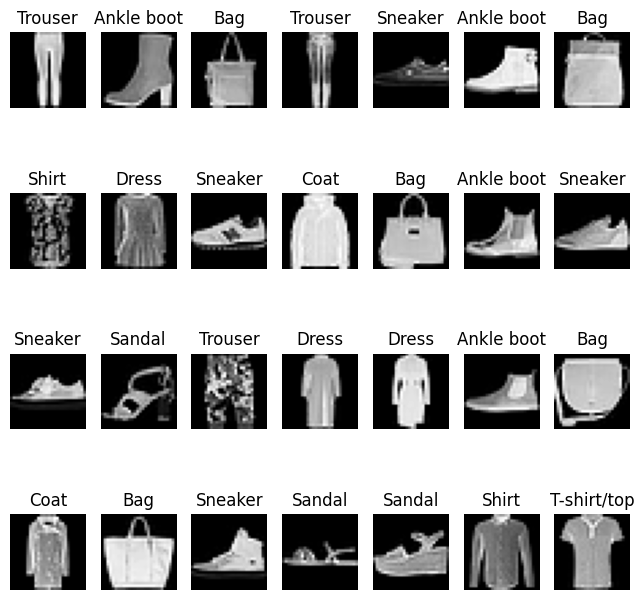

In [117]:
fig = plt.figure(figsize=(8,8))
rows,cols = 4,7

for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img,label = train_data[random_idx]
    plt.subplot(rows,cols,i)
    plt.imshow(img.squeeze(),
               cmap='gray')
    plt.axis(False)
    plt.title(train_data.classes[label])
plt.show()

In [118]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [119]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

## Dataloading

In [120]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [121]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

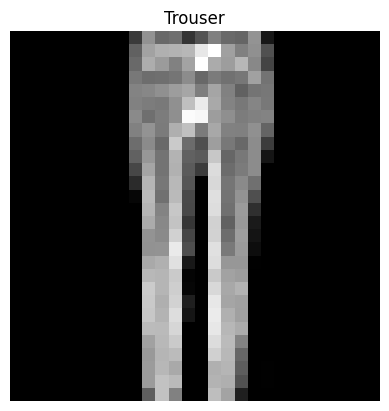

In [122]:
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
image,label = train_features_batch[random_idx],train_labels_batch[random_idx]

plt.imshow(image.squeeze(),
           cmap="gray")
plt.title(train_data.classes[label])
plt.axis(False)
plt.show()

## Baseline model

A baseline model is a simple model that is improved subsequently by adding complexity and experimentation.

---

Flatten is used to make a single dimension from a multidimensional tensor.<br>
This is used to make our images go from [1,28,28] to [1,784].

Essentially:
$$Flatten:\newline\space [ colour\_ channels,height,width ]\newline \downarrow \newline[ colour\_ channels,height\times width ] $$

In [123]:
flatten_model = nn.Flatten()

x = train_features_batch[0]
x.shape,flatten_model(x).shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [124]:
class FashionMNISTModel_0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    def forward(self,x):
        return self.layer_stack(x)

In [125]:
HIDDEN_UNITS=10
LEARNING_RATE=0.01
EPOCHS = 3

In [126]:
torch.manual_seed(42)

model_0 = FashionMNISTModel_0(
    input_shape=784, # 28*28
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

In [127]:
import requests
from pathlib import Path

# if not Path("helper_functions.py").is_file():
#     request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
#     with open("helper_functions.py","wb") as f:
#         f.write(request.content)

In [128]:
# from helper_functions import accuracy_fn
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

optimizer_0 = optim.SGD(
    params=model_0.parameters(),
    lr=LEARNING_RATE
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [129]:
from timeit import default_timer as timer
#!pip install tqdm  
from tqdm.auto import tqdm

def train_time(start: float,
               end: float,
               device: torch.device=None):
    """Prints the training duration."""
    total_time = end-start
    print(f"\nDevice: {device}\nTime:{total_time:.3f} seconds")

In [130]:
torch.manual_seed(42)

train_time_start = timer()
for epochs in tqdm(range(EPOCHS)):
    model_0.train()
    loss_train = 0 #zero because we will add to it per batch
    for batch,(X,y) in enumerate(train_dataloader):
        X,y = X.to(device),y.to(device)
        model_0.train()
        y_train_pred = model_0(X)
        # print(y_train_pred.device,y.device)
        loss = loss_fn(y_train_pred,y)
        loss_train+=loss.item()
        optimizer_0.zero_grad()
        loss.backward()
        optimizer_0.step()
    loss_train /= len(train_dataloader)

    loss_test,accuracy_test = 0,0 #zero because we will add to it per batch
    for X_test,y_test in test_dataloader:
        X_test,y_test = X_test.to(device),y_test.to(device)
        model_0.eval()
        with torch.inference_mode():
            y_test_pred = model_0(X_test)
            loss = loss_fn(y_test_pred,y_test)
            loss_test+=loss.item()
    loss_test /= len(test_dataloader)
    print(f"\nTrain loss: {loss_train:.4f}\nTest loss: {loss_train:.4f}")
train_time_end = timer()
train_time(start=train_time_start,
           end=train_time_end,
           device=torch.device(device))

 33%|███▎      | 1/3 [00:10<00:21, 10.70s/it]


Train loss: 0.9096
Test loss: 0.9096


 67%|██████▋   | 2/3 [00:21<00:10, 10.81s/it]


Train loss: 0.5573
Test loss: 0.5573


100%|██████████| 3/3 [00:32<00:00, 10.74s/it]


Train loss: 0.5027
Test loss: 0.5027

Device: cuda
Time:32.234 seconds


## Model 0 results and predictions

In [131]:
torch.manual_seed(42)

def eval_model(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               accuracy_fn) -> dict:
    loss,acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {'model_name':model.__class__.__name__,
    'model_loss': loss.item(),
    'model_accuracy' :acc}

In [132]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

for i,j in model_0_results.items():
    print(f"{i} : {j}")

100%|██████████| 313/313 [00:01<00:00, 248.84it/s]

model_name : FashionMNISTModel_0
model_loss : 0.5136751532554626
model_accuracy : 81.9988019169329


## Model 1

### Model

In [133]:
activation = nn.ReLU()

class FashionMNISTModel_1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            activation,
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            activation
        )
    def forward(self,x):
        return self.layer_stack(x)

In [134]:
torch.manual_seed(42)

model_1 = FashionMNISTModel_1(
    input_shape=784, # 28*28
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

optimizer_1 = optim.SGD(
    params=model_1.parameters(),
    lr=LEARNING_RATE
)
loss_fn = nn.CrossEntropyLoss().to(device)

### Functionizing train and test steps

In [145]:
def train_step(model: nn.Module,
               loss_fn: nn.Module,
               data_loader: DataLoader,
               optimizer: optim.Optimizer,
               accuracy_fn,
               device: torch.device = device) -> None:
    train_acc,train_loss = 0,0
    model.train()
    for batch,(X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        if accuracy_fn:
            train_acc+=accuracy_fn(y_true=y,
                                   y_pred=y_pred.argmax(dim=1))
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc /= len(data_loader)
    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}")

def test_step(model: nn.Module,
               loss_fn: nn.Module,
               data_loader: DataLoader,
               accuracy_fn,
               device: torch.device = device) -> None:
    test_loss,test_accuracy = 0,0
    model.eval()
    for X,y in test_dataloader:
        X,y = X.to(device),y.to(device)
        with torch.inference_mode():
            y_pred =model(X)
            loss = loss_fn(y_pred,y)
            test_loss+=loss.item()
            if accuracy_fn is not None:
                test_accuracy += accuracy_fn(y_true=y,
                                            y_pred=y_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_accuracy /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_accuracy:.5f}")

def print_dict(dictionary: dict):
    print()
    for i,j in dictionary.items():
        print(f"{i}: {j}")

def make_predictions(
        model: nn.Module,
        data: list,
        device: torch.device = device
):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.unsqueeze(dim=0).to(device)
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(),dim=0)
            prediction = pred_prob.argmax()
            pred_probs.append(pred_prob.cpu())

        return torch.stack(pred_probs)

### Running it

In [136]:
torch.manual_seed(42)

train_time_start = timer()
for epochs in tqdm(range(EPOCHS)):
    train_step(model=model_1,
               loss_fn=loss_fn,
               data_loader=train_dataloader,
               optimizer=optimizer_1,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(model=model_1,
              loss_fn=loss_fn,
              data_loader=test_dataloader,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end = timer()
train_time(start=train_time_start,
           end=train_time_end)

print_dict(eval_model(model=model_1,
                      data_loader=test_dataloader,
                      loss_fn=loss_fn,
                      accuracy_fn=accuracy_fn))

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.42179 | Train acc: 54.28667


 33%|███▎      | 1/3 [00:11<00:22, 11.18s/it]

Test loss: 1.12167 | Test acc: 62.15056
Train loss: 1.03359 | Train acc: 64.61167


 67%|██████▋   | 2/3 [00:22<00:11, 11.22s/it]

Test loss: 1.00019 | Test acc: 64.47684
Train loss: 0.95996 | Train acc: 66.05167


100%|██████████| 3/3 [00:33<00:00, 11.21s/it]


Test loss: 0.96338 | Test acc: 65.40535

Device: None
Time:33.643 seconds


100%|██████████| 313/313 [00:01<00:00, 240.37it/s]


model_name: FashionMNISTModel_1
model_loss: 0.9633837938308716
model_accuracy: 65.40535143769968


## CNN

### Model

In [137]:
class FashionMNISTModel_2(nn.Module):
    def __init__(self,input_shape: int,hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_0 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(7 * 7 * hidden_units),
                      out_features=output_shape)
        )
    def forward(self,x):
        x = self.conv_block_0(x)
        # print(x.shape)
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.classifier(x)
        return x

In [138]:
LEARNING_RATE=0.1
HIDDEN_UNITS=10

In [139]:
torch.manual_seed(42)

model_2 = FashionMNISTModel_2(input_shape=1, #number of colour channels
                              hidden_units=HIDDEN_UNITS,
                              output_shape=10).to(device)
optimizer_2 = optim.SGD(params=model_2.parameters(),
                        lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss().to(device)

### Demo of what convolve and maxpool do

In [140]:
torch.manual_seed(43)

rimg_batch = torch.randn(size=(32,1,28,28))
rimg_test = rimg_batch[0]

print(rimg_batch.shape)
print(rimg_test.shape)

conv_layer = nn.Conv2d(
    in_channels=1,
    out_channels=10,
    kernel_size=3,
    stride=1,
    padding=1
)
conv_layer_2 = nn.Conv2d(
    in_channels=10,
    out_channels=10,
    kernel_size=3,
    stride=1,
    padding=1
)
rimg_conv = conv_layer(rimg_test)

print(rimg_conv.shape)

maxpool_layer = nn.MaxPool2d(
    kernel_size=2
)
rimg_maxpool = maxpool_layer(rimg_conv)

print(rimg_maxpool.shape)

l1_res = maxpool_layer(conv_layer_2(conv_layer(rimg_batch)))
l2_res = maxpool_layer(conv_layer_2(conv_layer_2(l1_res)))

print(l2_res.shape)

flatten = nn.Flatten()

l3_res = flatten(l2_res)

print(l3_res.shape)

torch.Size([32, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([10, 28, 28])
torch.Size([10, 14, 14])
torch.Size([32, 10, 7, 7])
torch.Size([32, 490])


In [141]:
rimg_batch = torch.randn(size=(32,1,28,28)).to(device)

model_2.eval()
with torch.inference_mode():
    rimg_preds = model_2(rimg_batch)

print(rimg_preds.shape)

torch.Size([32, 10])


### Loop

In [142]:
start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    train_step(
        model=model_2,
        loss_fn=loss_fn,
        data_loader=train_dataloader,
        optimizer=optimizer_2,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(
        model=model_2,
        data_loader=test_dataloader,
        accuracy_fn=accuracy_fn,
        device=device,
        loss_fn=loss_fn
    )

end_time = timer()
train_time(start=start_time,end=end_time)
print_dict(eval_model(model_2,test_dataloader,loss_fn,accuracy_fn))

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.59110 | Train acc: 78.53167


 33%|███▎      | 1/3 [00:12<00:25, 12.88s/it]

Test loss: 0.39116 | Test acc: 86.21206
Train loss: 0.36641 | Train acc: 86.80500


 67%|██████▋   | 2/3 [00:25<00:13, 13.02s/it]

Test loss: 0.39222 | Test acc: 86.21206
Train loss: 0.32868 | Train acc: 88.15833


100%|██████████| 3/3 [00:39<00:00, 13.03s/it]


Test loss: 0.33177 | Test acc: 88.34864

Device: None
Time:39.095 seconds


100%|██████████| 313/313 [00:01<00:00, 214.85it/s]


model_name: FashionMNISTModel_2
model_loss: 0.3317704200744629
model_accuracy: 88.34864217252397


### Comparission of models

In [143]:
import pandas as pd

result_comparision = pd.DataFrame([
    eval_model(model=model_0,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn),
    eval_model(model=model_1,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn),
    eval_model(model=model_2,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
])

result_comparision.set_index("model_name",inplace=True)
result_comparision

100%|██████████| 313/313 [00:01<00:00, 208.08it/s]


,model_loss,model_accuracy
model_name,,
FashionMNISTModel_0,0.513675,81.998802
FashionMNISTModel_1,0.963384,65.405351
FashionMNISTModel_2,0.331770,88.348642


### Making predictions

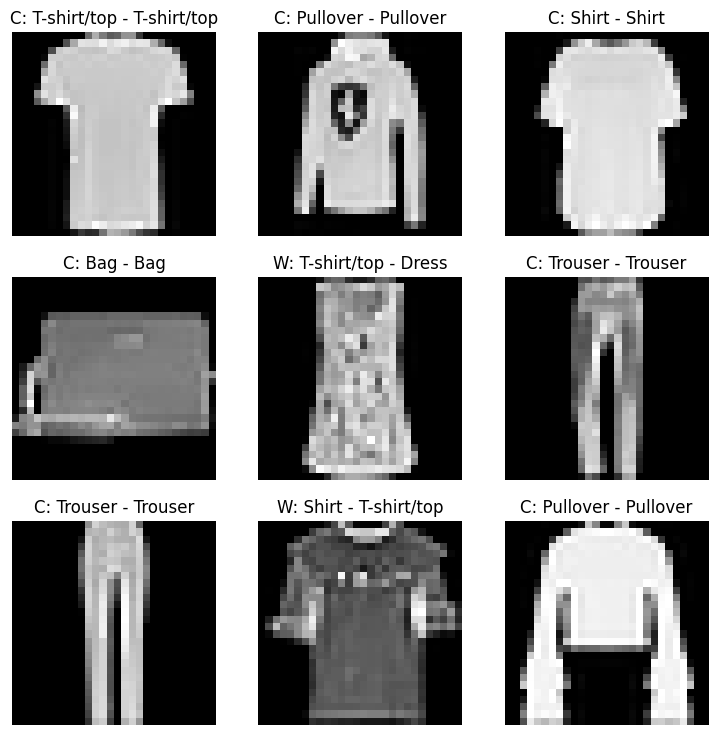

In [153]:
import random

test_samples = []
test_labels = []

for sample,label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_pred_probs = make_predictions(
    model=model_2,
    data=test_samples,
    device=device
)
test_pred_labels = test_pred_probs.argmax(dim=1)

plt.figure(figsize=(9,9))
rows,cols = 3,3
for i in range(1,rows*cols+1):
    t = f"{class_names[test_labels[i-1]]} - {class_names[test_pred_labels[i-1]]}"
    if test_labels[i-1] != test_pred_labels[i-1]:
        t = "W: "+t
    else:
        t = "C: "+t
    plt.subplot(rows, cols,i)
    plt.title(t)
    plt.imshow(test_samples[i-1].squeeze(),cmap="gray")
    plt.axis(False)
plt.show()